# A simple Client Credit Rating Model (Logistic Regression)

https://www.kaggle.com/datasets/satyajeetrai/credit-risk-dataset/data

Released under MIT License

Copyright (c) 2013 Mark Otto.

Copyright (c) 2017 Andrew Fong.

### Import Libraries

In [1]:
!pip install xgboost

In [37]:
import boto3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

### Load from S3 Bucket

In [38]:
# Set bucket and file
bucket = 'creditrisk*****'
file_key = 'dataset.csv'

# Load from S3
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=file_key)
df = pd.read_csv(obj['Body'])
df

,id,Duration in months,Credit history,Purpose of the credit,Credit amount,Status of savings account/bonds,Present employment(years),Installment rate in percentage of disposable income,personal_status,Other debtors / guarantors,...,Property,Age in years,Other installment plans (banks/stores),Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Status of existing checking account
0,1,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,2,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,3,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,4,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,5,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,good
996,997,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,good
997,998,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,...,car,38,none,own,1,skilled,1,none,yes,good
998,999,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,...,no known property,23,none,for free,1,skilled,1,yes,yes,bad


### Remove unuseful variables

In [39]:
df = df.drop(['id','Purpose of the credit','Other debtors / guarantors','Number of people being liable to provide maintenance for'], axis=1)

### Prepare Data

In [40]:
# Target and features
target_column = 'Status of existing checking account'
y = df[target_column].map({'good': 1, 'bad': 0})
X = df.drop(columns=[target_column])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Identify column types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

### Run Random Forest Model

In [41]:
# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()



# Model
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train_proc, y_train)

# Predict
y_prob = model.predict_proba(X_test_proc)[:, 1]
y_pred = (y_prob >= 0.45).astype(int)  # Lower threshold to improve recall
auc = roc_auc_score(y_test, y_prob)

# Evaluate
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['bad', 'good']))


Classification Report:
              precision    recall  f1-score   support

         bad       0.62      0.70      0.66        30
        good       0.86      0.81      0.84        70

    accuracy                           0.78       100
   macro avg       0.74      0.76      0.75       100
weighted avg       0.79      0.78      0.78       100



/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:05:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1742444421431/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Show Confusion Matrx

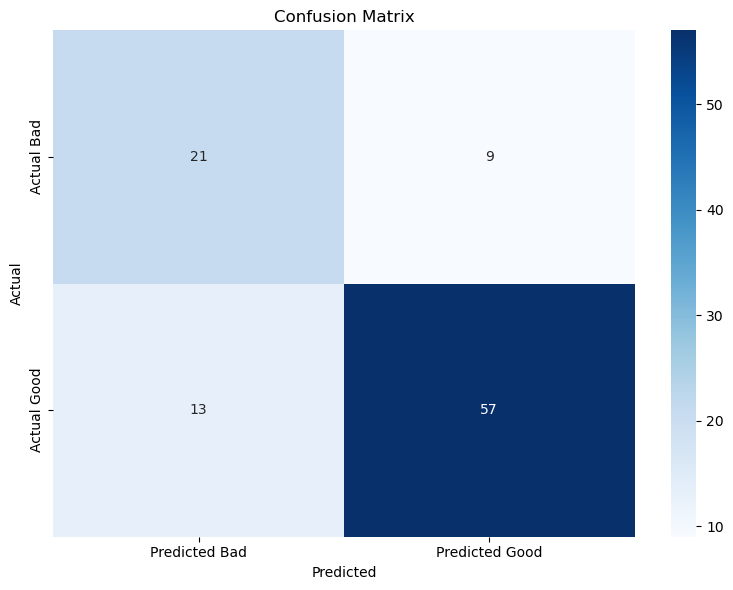

In [42]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Show ROC Curve

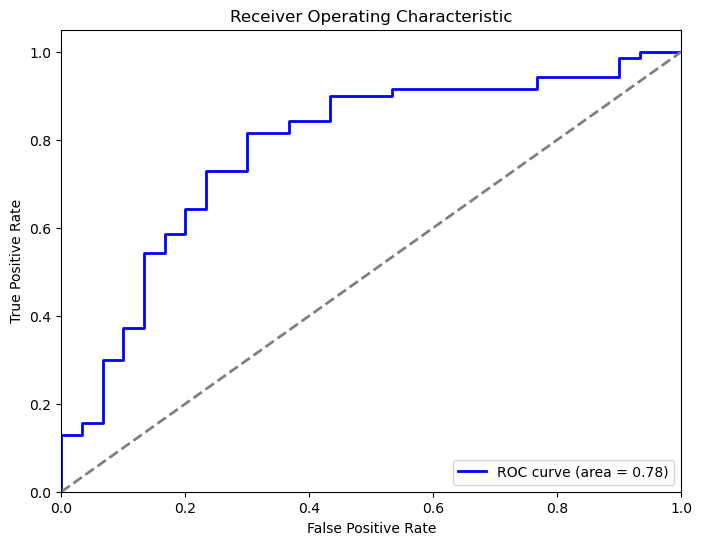

ROC AUC: 0.7786


In [43]:
# ROC curve
if roc_auc_score is not None:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

### Analyse Most Important Predictors

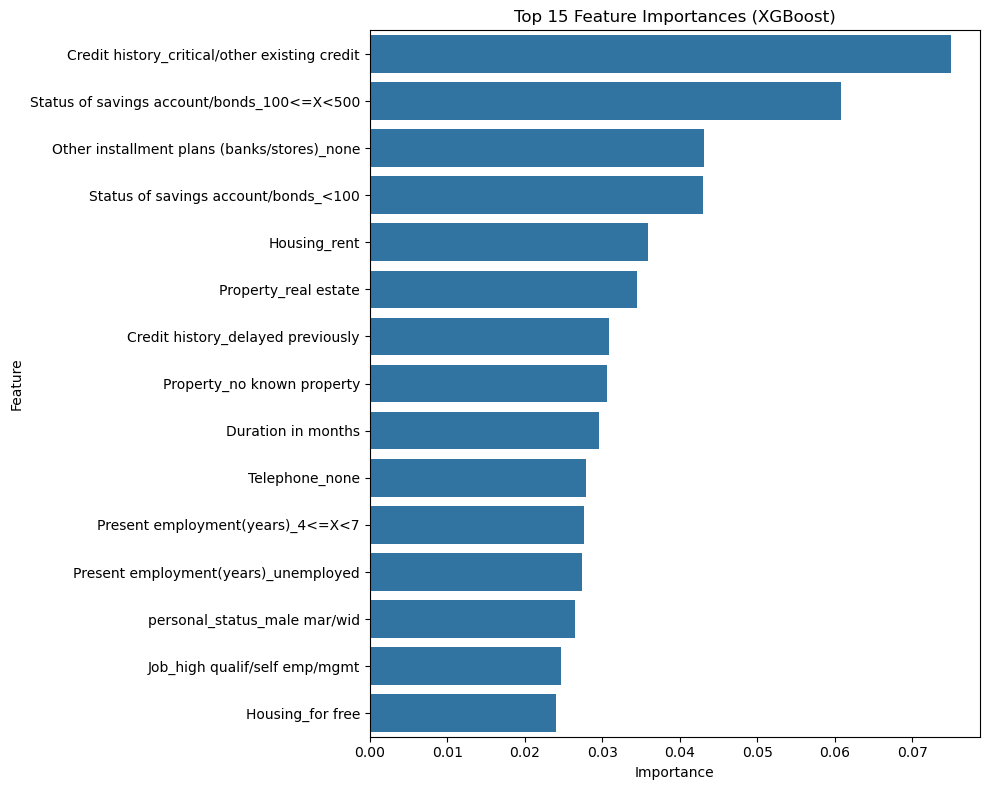

In [44]:
# Get feature names after preprocessing
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_feature_names)

# Get feature importances from the model
importances = model.feature_importances_

# Match feature names to importances
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top N
top_n = 15
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(top_n))
plt.title(f'Top {top_n} Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

### Conclusions

Accuracy is close to 80% while in a sample of 100 only 9 with "bad" credit are classified as "good". In general both the macro and weighted average are acceptable and the model due to fetaure importance is somewhat explainable. If the training data were 10, 100 or 1000 larger, not unusual for a medium and larger bank, i strongly belive that the model would be much more precise in its classification. 

Since this project had as a primary goal the use of different cloud platforms (AWS S3 and Sagemake and Google's BigQuery and Vertex AI) we will stop here and don't try any Deep NN solutions. Avoiding also the problem about economic data and model explainability.